# Point Colaboratory to Google Drive

In [1]:
# In the following drive folder, I save the dataset, the models and all other 
# files required for training and prediction
from google.colab import drive
drive.mount('/content/gdrive')
datapath = '/content/gdrive/My Drive/TESI/' 

Mounted at /content/gdrive


# Import

In [2]:
# Install a library not available in Colab
!pip install stop_words

  Created wheel for stop-words: filename=stop_words-2018.7.23-py3-none-any.whl size=32912 sha256=691bf1ddecba4d533da1f02259ec4f15c47cb6dbb20d66c30d760d8a9b431789
  Stored in directory: /root/.cache/pip/wheels/fb/86/b2/277b10b1ce9f73ce15059bf6975d4547cc4ec3feeb651978e9
Successfully built stop-words


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
from operator import itemgetter
import random
import datetime 
from pandas.api.types import is_numeric_dtype # used for one-hot encoding
import math
import tqdm.notebook as tq
import itertools
import pickle # to save and load sklearn models

# Text mining
from stop_words import get_stop_words
from string import punctuation 
import re
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter
from wordcloud import WordCloud
from scipy import sparse
from scipy.sparse import hstack, vstack
from nltk.stem import SnowballStemmer

# Sklearn utilities
# from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import balanced_accuracy_score

from collections import Counter
from imblearn.over_sampling import RandomOverSampler 
from imblearn.under_sampling import RandomUnderSampler

# Sklearn models
from sklearn.ensemble import GradientBoostingClassifier


import warnings
warnings.filterwarnings("ignore")


/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


# Pre-processing

### Import the dataset

In [4]:
dataset_path = datapath + 'dataset/test/data-new-1.csv'
data = pd.read_csv(dataset_path)
print("Shape of the dataset: {}".format(data.shape))

Shape of the dataset: (7876, 23)


### Merge note with workdesc

In [5]:
data.workdesc[~data.note.isnull()] = data.workdesc[~data.note.isnull()] + ' ' + data.note[~data.note.isnull()]

### Drop columns with almost all null values and useless ones

In [6]:
data.drop(['description', 'nr_fattura', 'note', 'umid', 'app_ins', 'jobregistered'], inplace=True, axis=1)

In [7]:
# Check how missing values are distributed across each variable (i.e., column)
print(f'Total number of rows: {data.shape[0]}')
print()
print('MISSING VALUES PER VARIABLE:\n')
data.apply(lambda x: sum(x.isnull())) # apply applies the function column-wise

Total number of rows: 7876

MISSING VALUES PER VARIABLE:



id                   0
resid                0
jobid                0
jobtaskdt            0
pay                  0
workdesc             0
qty                  0
jobtaskid            0
flg_trasferta        0
data_ins             0
flg_prepagato        0
custid               0
flg_straordinario    0
flg_status           0
sede                 0
tipo_update          0
changed_on           0
dtype: int64

## Filter by rows


### 1) Remove flg_status = A

In [8]:
status_a = data.flg_status == 'A'
status_a = status_a[status_a == True].index.tolist()
data = data.drop(status_a)

### 2) group by id and keep only last approved (the higher)

In [9]:
data_group = data.groupby(['id'])
da_rimuovere = []
for name, group in data_group:
    
    app = group.tipo_update == 'approvato'
    app = app[app == True].index.tolist()
    if app:
        app.pop(0)
        da_rimuovere += app
data = data.drop(da_rimuovere)

data.drop('flg_status', inplace=True, axis=1)

### 3) group by id and keep only the first cambio_commessa (the lower)

In [10]:
data_group = data.groupby(['id'])
da_rimuovere = []
for name, group in data_group:
    
    app = group.index.tolist()
    if app:
        app.pop()
        da_rimuovere += app

data = data.drop(da_rimuovere)

In [11]:
freqs = data.tipo_update.value_counts()
freqs

approvato          6972
cambio_commessa     187
Name: tipo_update, dtype: int64

In [12]:
freqs['cambio_commessa']/ (freqs['cambio_commessa'] + freqs['approvato'])

0.026120966615449086

## Manual feature engineering

Columns to be removed: id, changed_on

In [13]:
data = data[['workdesc', 'jobid', 'jobtaskid', 'resid', 'custid', 'qty', 'sede', 'jobtaskdt', 'data_ins', 'flg_trasferta', 'pay', 'flg_prepagato', 'flg_straordinario', 'tipo_update']]

### Day

In [14]:
def date_to_days(d):
    d1 = pd.to_datetime(d, format='%Y-%m-%d')
    diff = d1 - pd.to_datetime('2020-07-01', format='%Y-%m-%d')
    return diff.days

In [15]:
data['day'] = data['jobtaskdt'].apply(lambda x: date_to_days(x))

### Delay

In [16]:
data['day1'] = data['data_ins'].apply(lambda x: date_to_days(x))
data['delay'] = data.day1 - data.day

In [17]:
data = data[['workdesc', 'jobid', 'jobtaskid', 'resid', 'custid', 'qty', 'sede', 'day', 'delay', 'flg_trasferta', 'pay', 'flg_prepagato', 'flg_straordinario', 'tipo_update']]

### Area

In [18]:
resid_df_update = pd.read_csv(datapath + 'dataset/id-area.csv')#, sep = ' ', header=None)
resid_df_update['Gruppi Utenti'] = resid_df_update['Gruppi Utenti'].apply(lambda x: x.strip())

In [19]:
update = {'Acquisti' : 'ACQ',
          'Amministrazione' : 'AMMINISTRAZIONE', 
          'Autentica' : 'AMMINISTRAZIONE',
          'Business Inteligence' : 'BI',
          'Commerciale' : 'COMMERCIALE MTK',
          'Consulenti Esterni' : 'OTHER',
          'Database Administrator' : 'DBA',
          'Developers' : 'SOA',
          'Legal' : 'AMMINISTRAZIONE',
          'Marketing' : 'MARKETING',
          'Presidio' : 'PRESIDIO',
          'Service Design' : 'DESIGN',
          'Sistemisti' : 'SISTEMISTI'}

In [20]:
mapping = resid_df_update['Gruppi Utenti'].apply(lambda x: update[x])
mapping.index = resid_df_update['ID']

In [21]:
def resid_to_area(r):
    if r in mapping.index:
        return mapping[r]
    else:
        return 'OTHER'

In [22]:
data['area'] = data['resid'].apply(lambda x: resid_to_area(x))

In [23]:
data = data[['workdesc', 'jobid', 'jobtaskid', 'resid', 'area', 'custid', 'qty', 'sede', 'day', 'delay', 'flg_trasferta', 'pay', 'flg_prepagato', 'flg_straordinario', 'tipo_update']]

## Remove duplicates

In [24]:
data = data[~data.duplicated()]

## Text cleaning

In [25]:
data = data.reset_index()
data = data.drop(['index'], inplace=False, axis=1)

In [26]:
# Define the ilst of stopwords (both english and italian) and also punctuation marks
stop_words = get_stop_words('it')
stop_words_en = get_stop_words('en')

# Create the final list
stop_words_punct_eng = stop_words + stop_words_en + list(punctuation) + ["’"] 

Compute the number of different words after removing punctuations and both italian and english stopwords

In [27]:
def clean_text_iteng_url_mail(text):
    text = re.sub("(\w+:\/\/\S+)", " ", text)
    text = re.sub("(\S*@\S*\s)", " ", text)
    text = re.sub("[\.\,\!\?\:\;\-\=\'\...\"\@\#\_!#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~]", " ", text)
    words = text.lower()
    words = words.split()
    noise_free_words = [word for word in words if word not in stop_words_punct_eng and not word.isdigit()] 
    noise_free_text = " ".join(noise_free_words) 
    return noise_free_text

In [28]:
words_v_iteng_url_mail = data["workdesc"].apply(lambda s: clean_text_iteng_url_mail(s))

In [29]:
words_iteng_url_mail = set()
for i in range(len(words_v_iteng_url_mail)):
    words_iteng_url_mail.update(words_v_iteng_url_mail[i].lower().split())

In [30]:
stemmer = SnowballStemmer("italian")

def clean_text(text):
    text = re.sub("(\w+:\/\/\S+)", " ", text)
    text = re.sub("(\S*@\S*\s)", " ", text)
    text = re.sub("[\.\,\!\?\:\;\-\=\'\...\"\@\#\_!#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~]", " ", text)
    words = text.lower()
    words = words.split()
    # noise_free_words = [word for word in words if word not in stop_words_punct] 
    # noise_free_words = [word for word in words if word not in stop_words and not word.isdigit()] 
    noise_free_words = [word for word in words if word not in stop_words_punct_eng and not word.isdigit()] 
    noise_free_words = [stemmer.stem(w) for w in noise_free_words]
    noise_free_text = " ".join(noise_free_words) 
    # return noise_free_words
    return noise_free_text

In [31]:
data["cleaned_workdesc"] = data["workdesc"].apply(lambda s: clean_text(s))

## Hande categorical variables

In [32]:
data[['jobid','jobtaskid', 'resid', 'custid', 'sede']] = data[['jobid','jobtaskid', 'resid', 'custid', 'sede']].astype(str)
data[['flg_trasferta','pay', 'flg_prepagato', 'flg_straordinario']] = data[['flg_trasferta','pay', 'flg_prepagato', 'flg_straordinario']].astype(int)
data = data.drop(['workdesc'], inplace=False, axis=1)

In [33]:
categorical_features = [col for col in data.columns if not is_numeric_dtype(data[col]) and col != 'tipo_update' and col != 'cleaned_workdesc']

In [34]:
# In pandas we can achieve easily one-hot encoding using the 'get_dummies()' function
categorical_features = [col for col in data.columns if not is_numeric_dtype(data[col]) and col != 'tipo_update' and col != 'workdesc' and col != 'cleaned_workdesc']
data = pd.get_dummies(data, columns = categorical_features)

## Encoding Label

In [35]:
y_labels = ['approvato', 'cambio_commessa']

In [36]:
data.tipo_update = data.tipo_update.map(lambda x: 0 if x=='approvato' else 1)

In [37]:
header = pd.read_csv(datapath + 'dataset/header.csv')

In [38]:
data = data.reindex(columns = header.columns, fill_value=0)

In [39]:
data

,qty,day,delay,flg_trasferta,pay,flg_prepagato,flg_straordinario,jobid_100,jobid_107,jobid_110,jobid_118,jobid_119,jobid_123,jobid_125,jobid_126,jobid_135,jobid_157,jobid_158,jobid_173,jobid_174,jobid_175,jobid_177,jobid_178,jobid_179,jobid_187,jobid_203,jobid_209,jobid_210,jobid_227,jobid_231,jobid_2457,jobid_2488,jobid_2509,jobid_2516,jobid_2528,jobid_2534,jobid_2538,jobid_2579,jobid_2580,jobid_2598,...,custid_4340,custid_4343,custid_4361,custid_4370,custid_4375,custid_4379,custid_4391,custid_44,custid_4404,custid_4410,custid_4414,custid_4415,custid_4429,custid_4430,custid_4435,custid_4439,custid_4447,custid_4449,custid_4453,custid_4461,custid_4466,custid_4469,custid_4475,custid_4480,custid_4484,custid_48,custid_59,custid_62,custid_9,sede_1.0,sede_2.0,sede_3.0,sede_4.0,sede_5.0,sede_6.0,sede_7.0,sede_8.0,sede_9.0,cleaned_workdesc,tipo_update
0,0.5,304,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,controll fluss mattutin controll fluss mattutin,0
1,0.5,305,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,chiam vuot nessun ticket registr sysaid poss a...,0
2,0.5,305,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,ticket,0
3,8.0,306,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,tkt sr,0
4,8.0,306,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,comm,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7144,3.0,387,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,verif creazion ordin permess ruol salesforc,0
7145,3.5,390,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,svilupp app magazzin wb,0
7146,1.0,390,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,predisposizion ambient problem connession saas...,0
7147,6.5,386,4,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,implement dat lineag talend,0


In [40]:
filter = data.cleaned_workdesc == ''
data = data[~ filter]

In [41]:
# data.to_csv(datapath + 'dataset/data9_test.csv', index=False)

# Models

In [42]:
# data = pd.read_csv(datapath + 'dataset/data9_test.csv')
# data = data[~ data.cleaned_workdesc.isna()]
# data

## BOW

In [43]:
def vectorizer(X_train, max_features=1000, n_min=1, n_max=1, vect_type='cv'):
    if vect_type == 'cv':
        vect = CountVectorizer(
            max_features = max_features,
            ngram_range = (n_min, n_max),     # (1,1) means only unigrams, (1,2) means unigrams and bigrams, (2,2) only bigrams
            )
        
    if vect_type == 'tfidf':
         vect = TfidfVectorizer(
            max_features = max_features,
            ngram_range = (n_min, n_max),     # (1,1) means only unigrams, (1,2) means unigrams and bigrams, (2,2) only bigrams
            )

    vect_train = vect.fit_transform(X_train['cleaned_workdesc'])
    vect_train = pd.DataFrame(vect_train.toarray(), columns=vect.get_feature_names())
    X_train_v = pd.concat([X_train.reset_index().drop(['index'], inplace=False, axis=1), vect_train], axis=1)
    X_train_v.drop(['cleaned_workdesc'], inplace=True, axis=1)
    
    return X_train_v, vect

### Auxiliary evaluation functions

In [44]:
def metrics(true_positive, true_negative, false_positive, false_negative):
  
    accuracy = (true_positive + true_negative) / (true_positive + true_negative + false_negative + false_positive)
    precision = true_positive / (true_positive + false_positive)
    sensitivity = true_positive / (true_positive + false_negative)
    specificity = true_negative / (true_negative + false_positive)
    weighted_accuracy = (sensitivity + specificity) / 2
    mcc_numerator = (true_positive * true_negative) - (false_positive * false_negative)
    mcc_denominator_squared = (true_positive + false_positive) * (true_positive + false_negative) * (true_negative + false_positive) * (true_negative + false_negative)
    mcc = mcc_numerator / math.sqrt(mcc_denominator_squared)
    f1_score = 2 * (precision * sensitivity) / (precision + sensitivity)
    
    return {
            "Accuracy": accuracy,
            "Weighted accuracy": weighted_accuracy,
            "Precision": precision,
            "Sensitivity": sensitivity,
            "Specificity": specificity,
            "MCC": mcc,
            "F-score": f1_score
            }


In [45]:
def metrics_results(true, pred):

    true_positive = np.sum(np.logical_and(true == 1, pred == 1))
     
    # remove from actual positive the TP to get FN 
    false_negative = np.sum(true) - true_positive

    # remove from predicted positive the TP to get FP
    false_positive = np.sum(pred) - true_positive

    true_negative = np.sum(np.logical_and(true == 0, pred == 0))
    
    conf_matrix = pd.DataFrame(np.array([[true_positive, false_positive], [false_negative, true_negative]]), 
                               index=['Positive pred', 'Negative pred'], 
                               columns=['Actual positive', 'Actual negative'])

    return conf_matrix, metrics(true_positive, true_negative, false_positive, false_negative)  

In [46]:
def accuracy(y_pred, y_true):
    '''
    input y_pred: ndarray of shape (N,)
    input y_true: ndarray of shape (N,)
    '''
    return (1.0 * (y_pred == y_true)).mean()

## Training

In [47]:
X_test, y_test = data.iloc[:,:-1], data.tipo_update

#### Best model - accuracy

In [48]:
# Load vectorizer
vect = pickle.load(open(datapath + 'models/vect_best_acc.sav', 'rb'))

In [49]:
vect_test = vect.transform(X_test['cleaned_workdesc'])
vect_test = pd.DataFrame(vect_test.toarray(), columns=vect.get_feature_names())
X_test_v = pd.concat([X_test.reset_index().drop(['index'], inplace=False, axis=1), vect_test], axis=1)
X_test_v.drop(['cleaned_workdesc'], inplace=True, axis=1)

In [50]:
# load the model from disk
model = pickle.load(open(datapath + 'models/model_best_acc.sav', 'rb'))

In [51]:
y_test_pred = model.predict(X_test_v)

test_acc = accuracy(y_test_pred, y_test)
test_bacc = balanced_accuracy_score(y_test, y_test_pred)
print(f'Test accuracy: {test_acc}')
print(f'Test balanced accuracy: {test_bacc}')

Test accuracy: 0.9473454545454545
Test balanced accuracy: 0.6194677033492824


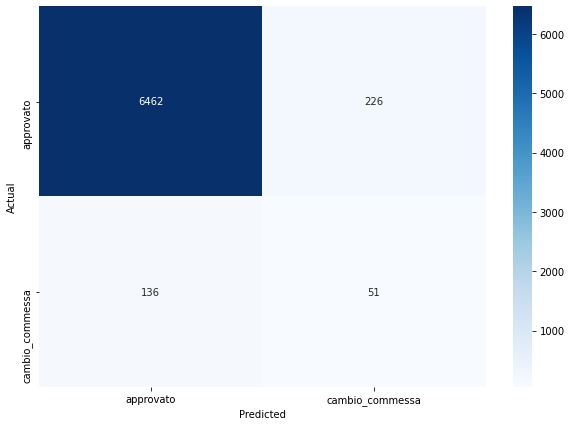

In [52]:
conf_mat = confusion_matrix(y_test, y_test_pred)
fig, ax = plt.subplots(figsize=(10,7))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap=plt.cm.Blues, xticklabels=y_labels, yticklabels=y_labels)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [53]:
conf_matrix, metric_results = metrics_results(y_test, y_test_pred)
print('CLASSIFICATION METRICS')
for k in metric_results:
    print(f'{k}: {metric_results[k]:.3}')

CLASSIFICATION METRICS
Accuracy: 0.947
Weighted accuracy: 0.619
Precision: 0.184
Sensitivity: 0.273
Specificity: 0.966
MCC: 0.198
F-score: 0.22


In [54]:
# np.savetxt(datapath + "results/y_test_pred_acc.csv", y_test_pred, delimiter=",")

#### Best model - balanced accuracy

In [55]:
# Load vectorizer
vect = pickle.load(open(datapath + 'models/vect_best_bacc.sav', 'rb'))

In [56]:
vect_test = vect.transform(X_test['cleaned_workdesc'])
vect_test = pd.DataFrame(vect_test.toarray(), columns=vect.get_feature_names())
X_test_v = pd.concat([X_test.reset_index().drop(['index'], inplace=False, axis=1), vect_test], axis=1)
X_test_v.drop(['cleaned_workdesc'], inplace=True, axis=1)

In [57]:
# load the model from disk
model = pickle.load(open(datapath + 'models/model_best_bacc.sav', 'rb'))

In [58]:
y_test_pred = model.predict(X_test_v)

test_acc = accuracy(y_test_pred, y_test)
test_bacc = balanced_accuracy_score(y_test, y_test_pred)
print(f'Test accuracy: {test_acc}')
print(f'Test balanced accuracy: {test_bacc}')

Test accuracy: 0.8522181818181818
Test balanced accuracy: 0.6485452434562342


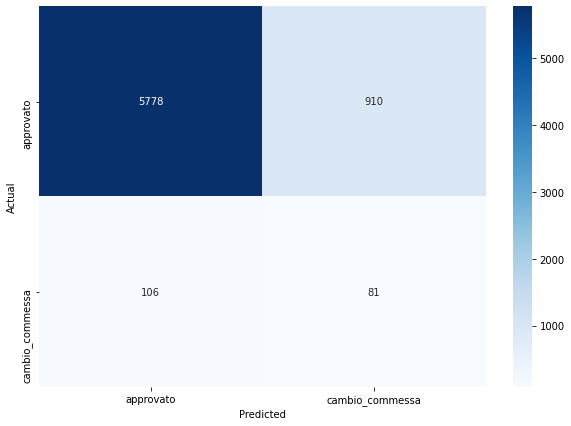

In [59]:
# Test set
conf_mat = confusion_matrix(y_test, y_test_pred)
fig, ax = plt.subplots(figsize=(10,7))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap=plt.cm.Blues, xticklabels=y_labels, yticklabels=y_labels)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [60]:
conf_matrix, metric_results = metrics_results(y_test, y_test_pred)
print('CLASSIFICATION METRICS')
for k in metric_results:
    print(f'{k}: {metric_results[k]:.3}')

CLASSIFICATION METRICS
Accuracy: 0.852
Weighted accuracy: 0.649
Precision: 0.0817
Sensitivity: 0.433
Specificity: 0.864
MCC: 0.138
F-score: 0.138


In [61]:
# np.savetxt(datapath + "results/y_test_pred_bacc.csv", y_test_pred, delimiter=",")